In [6]:
%config Completer.use_jedi = False
from snowflake.snowpark.session import Session
from snowflake.snowpark import DataFrame, Window
from snowflake.snowpark.types import *
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import col, lit

# Snowflake connection info is saved in config.py
from config import snowflake_conn_prop

In [ ]:
session = Session.builder.configs(snowflake_conn_prop).create()
session.sql("use role {}".format(snowflake_conn_prop['role'])).collect()
session.sql("use database {}".format(snowflake_conn_prop['database'])).collect()
session.sql("use schema {}".format(snowflake_conn_prop['schema'])).collect()
session.sql("use warehouse {}".format(snowflake_conn_prop['warehouse']))
print(session.sql('select current_warehouse(), current_database(), current_schema(), current_user()').collect())

In [5]:
df = session.table("RETAIL")
df.show()

-------------------------------------------------------------------------------------------------------------------
|"INVOICENO"  |"STOCKCODE"  |"DESCRIPTION"  |"QUANTITY"  |"INVOICEDATE"  |"UNITPRICE"  |"CUSTOMERID"  |"COUNTRY"  |
-------------------------------------------------------------------------------------------------------------------
|             |             |               |            |               |             |              |           |
-------------------------------------------------------------------------------------------------------------------



In [19]:
df.describe().show()

---------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"INVOICENO"  |"STOCKCODE"  |"DESCRIPTION"                   |"QUANTITY"  |"UNITPRICE"        |"CUSTOMERID"       |"COUNTRY"    |
---------------------------------------------------------------------------------------------------------------------------------------------
|count      |541909       |541909       |540455                          |541909      |541909.0           |406829.0           |541909       |
|mean       |NULL         |NULL         |NULL                            |NULL        |4.61111362         |15287.69057        |NULL         |
|stddev     |NULL         |NULL         |NULL                            |NULL        |96.75985306153116  |1713.600303321635  |NULL         |
|min        |536365       |10002        | 4 PURPLE FLOCK DINNER CANDLES  |-1          |-11062.06          |12346.0            |Australia    |
|max  

In [5]:
df = df.dropna()
df = df.filter("QUANTITY > 0 and UNITPRICE > 0")
df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------
|"INVOICENO"  |"STOCKCODE"  |"DESCRIPTION"                        |"QUANTITY"  |"INVOICEDATE"        |"UNITPRICE"  |"CUSTOMERID"  |"COUNTRY"       |
----------------------------------------------------------------------------------------------------------------------------------------------------
|536365       |85123A       |WHITE HANGING HEART T-LIGHT HOLDER   |6           |2010-12-01 08:26:00  |2.55         |17850         |United Kingdom  |
|536365       |71053        |WHITE METAL LANTERN                  |6           |2010-12-01 08:26:00  |3.39         |17850         |United Kingdom  |
|536365       |84406B       |CREAM CUPID HEARTS COAT HANGER       |8           |2010-12-01 08:26:00  |2.75         |17850         |United Kingdom  |
|536365       |84029G       |KNITTED UNION FLAG HOT WATER BOTTLE  |6           |2010-12-01 08:26:00  |3.39

In [20]:
df.group_by("COUNTRY").count().show()

----------------------------
|"COUNTRY"       |"COUNT"  |
----------------------------
|United Kingdom  |495478   |
|France          |8557     |
|Australia       |1259     |
|Netherlands     |2371     |
|Germany         |9495     |
|Norway          |1086     |
|Switzerland     |2002     |
|Spain           |2533     |
|Poland          |341      |
|Portugal        |1519     |
----------------------------



In [21]:
df = df.filter("COUNTRY = 'United Kingdom'")

In [22]:
df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------
|"INVOICENO"  |"STOCKCODE"  |"DESCRIPTION"                        |"QUANTITY"  |"INVOICEDATE"        |"UNITPRICE"  |"CUSTOMERID"  |"COUNTRY"       |
----------------------------------------------------------------------------------------------------------------------------------------------------
|536365       |85123A       |WHITE HANGING HEART T-LIGHT HOLDER   |6           |2010-12-01 08:26:00  |2.55         |17850         |United Kingdom  |
|536365       |71053        |WHITE METAL LANTERN                  |6           |2010-12-01 08:26:00  |3.39         |17850         |United Kingdom  |
|536365       |84406B       |CREAM CUPID HEARTS COAT HANGER       |8           |2010-12-01 08:26:00  |2.75         |17850         |United Kingdom  |
|536365       |84029G       |KNITTED UNION FLAG HOT WATER BOTTLE  |6           |2010-12-01 08:26:00  |3.39

In [23]:
df = df.join(df.select(F.max("INVOICEDATE").alias("NOW")))

#RECENCY, FREQUENCY, MONETARY
df_tf = df.group_by("CUSTOMERID")\
          .agg(F.max("INVOICEDATE"),\
               F.max("NOW"),\
               F.sum(col("QUANTITY")*col("UNITPRICE")).alias("Monetary"),\
               F.count("INVOICENO").alias("Frequency")).select("CUSTOMERID","Frequency","Monetary",\
                                    F.datediff("days",col("MAX(INVOICEDATE)"),col("MAX(NOW)")).alias("RECENCY"))

df_tf.show()

----------------------------------------------------------
|"CUSTOMERID"  |"FREQUENCY"  |"MONETARY"     |"RECENCY"  |
----------------------------------------------------------
|17850         |312          |5288.6300000   |302        |
|13047         |196          |3079.1000000   |31         |
|13748         |28           |948.2500000    |95         |
|15100         |6            |635.1000000    |330        |
|15291         |109          |4596.5100000   |25         |
|17809         |64           |4627.6200000   |16         |
|16098         |67           |2005.6300000   |87         |
|18074         |13           |489.6000000    |373        |
|17420         |30           |598.8300000    |50         |
|17511         |1076         |88125.3800000  |2          |
----------------------------------------------------------



In [24]:
freq_99pc = df_tf.select(F.percentile_cont(0.99).within_group("FREQUENCY")).collect()
rec_99pc = df_tf.select(F.percentile_cont(0.99).within_group("RECENCY")).collect()
mon_99pc = df_tf.select(F.percentile_cont(0.99).within_group("MONETARY")).collect()

df_tf = df_tf.filter((col("FREQUENCY") < freq_99pc[0][0]) & \
                     (col("RECENCY") < rec_99pc[0][0]) & \
                     (col("MONETARY") < mon_99pc[0][0]))

<Axes: xlabel='MONETARY', ylabel='Count'>

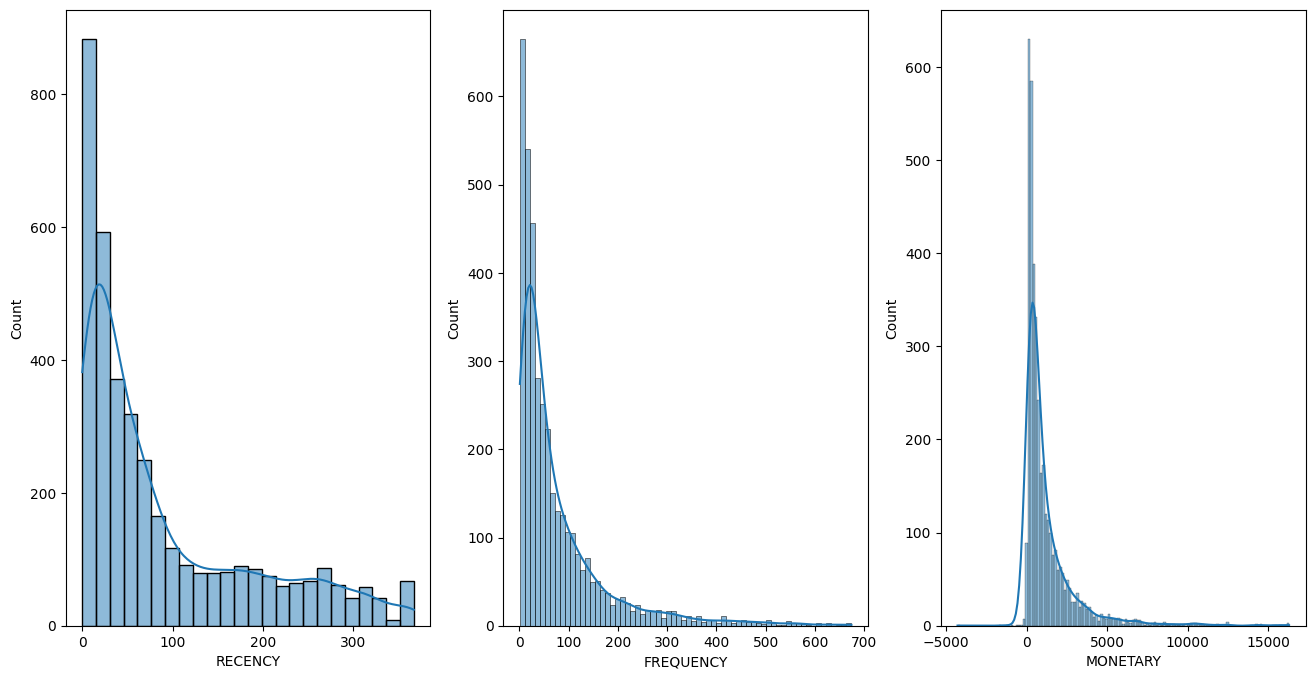

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

df_pd = df_tf.select("CUSTOMERID", "FREQUENCY", "RECENCY", "MONETARY").toPandas()

# Recency distribution plot
sns.histplot(df_pd['RECENCY'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(df_pd['FREQUENCY'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(df_pd['MONETARY'], kde=True, ax=ax[2])

In [26]:
# Implementation code for the stored procedure
def kmeans_cluster (session: Session, max_iter: int, iterate: int) -> str:
        
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans


    scaler = StandardScaler()
    scaler.fit(df_pd[["FREQUENCY", "RECENCY", "MONETARY"]])
    print(scaler.mean_)
    df_train = scaler.transform(df_pd[["FREQUENCY", "RECENCY", "MONETARY"]])
    print (df_train)
    inertia = []
    results = []
    
    #sdf = session.createDataFrame(pdf_rules)
    #sdf.write.saveAsTable(to_table,mode="overwrite")


    if iterate==1:
        K = range(2,max_iter)
        for k in K:
            model = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(df_train)
            inertia.append(model.inertia_)
            results = inertia
    else:
        df_pd['Cluster'] = KMeans(n_clusters=max_iter, init='k-means++', random_state=42).fit(df_train).labels_
        df_output = session.createDataFrame(df_pd)
        df_output.write.saveAsTable("RFM_Clusters",mode="overwrite")
        results = "MODEL CREATED"
        
    return results

In [27]:
from snowflake.snowpark.functions import sproc

# This adds the necessary packages to our Python environment in Snowflake
# session.clear_packages()
session.add_packages("snowflake-snowpark-python","pandas","scikit-learn")

# We need a stage to host the stored proc
_ = session.sql('CREATE STAGE IF NOT EXISTS MODELS').collect()

# Register the stored proc
session.sproc.register(kmeans_cluster, name="kmeans_cluster", is_permanent=True, stage_location="@models", replace=True)

The version of package scikit-learn in the local environment is 1.2.1, which does not fit the criteria for the requirement scikit-learn. Your UDF might not work when the package version is different between the server and your local environment
Failed to execute query [queryID: 01aaa668-3200-aac2-0000-0003728670ed] 
CREATE OR REPLACE 
  PROCEDURE kmeans_cluster(arg1 BIGINT,arg2 BIGINT)
RETURNS STRING
LANGUAGE PYTHON 
RUNTIME_VERSION=3.8
IMPORTS=('@models/kmeans_cluster/udf_py_186876245.zip')
PACKAGES=('snowflake-snowpark-python','pandas','scikit-learn','cloudpickle==2.0.0')
HANDLER='udf_py_186876245.compute'
EXECUTE AS OWNER



391529 (42501): SQL compilation error: Anaconda terms must be accepted by ORGADMIN to use Anaconda 3rd party packages. Please follow the instructions at https://docs.snowflake.com/en/developer-guide/udf/python/udf-python-packages.html#using-third-party-packages-from-anaconda.


SnowparkSQLException: (1304): 01aaa668-3200-aac2-0000-0003728670ed: 391529 (42501): SQL compilation error: Anaconda terms must be accepted by ORGADMIN to use Anaconda 3rd party packages. Please follow the instructions at https://docs.snowflake.com/en/developer-guide/udf/python/udf-python-packages.html#using-third-party-packages-from-anaconda.

In [14]:
max_iter = 12
results = session.call("kmeans_cluster", max_iter, 1)
inertia = np.array(results[1:-1].split(',')).astype(float)

Failed to execute query [queryID: 01aaa662-3200-aac6-0000-00037286907d] CALL kmeans_cluster(12 :: INT, 1 :: INT)
002140 (42601): SQL compilation error:
Unknown function KMEANS_CLUSTER


SnowparkSQLException: (1304): 01aaa662-3200-aac6-0000-00037286907d: 002140 (42601): SQL compilation error:
Unknown function KMEANS_CLUSTER

In [15]:
import matplotlib.pyplot as plt

K = range(2,max_iter)
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Chart')
plt.show()

NameError: name 'inertia' is not defined

<Figure size 1600x800 with 0 Axes>

In [23]:
max_iter = 4
results = session.call("kmeans_cluster", max_iter, 0)